In [1]:
from arduino import Arduino_Stepper

In [24]:
from pyvisa import ResourceManager
rm = ResourceManager()
rm.list_resources()

('ASRL3::INSTR',
 'USB-1208HS-4AO (1EF1478) - Device ADDRESS = 198',
 'USB-231 (217D955) - Device ADDRESS = 297')

In [25]:
from utilities import PiecManager
pm = PiecManager()
pm.list_resources()

('ASRL3::INSTR',
 'USB-1208HS-4AO (1EF1478) - Device ADDRESS = 198',
 'USB-231 (217D955) - Device ADDRESS = 297')

In [3]:
control = Arduino_Stepper('ASRL3::INSTR')

In [4]:
control.idn()

'Custom Arduino_Stepper Object at ASRL3::INSTR'

In [17]:
control.step(20,0) #0 is CCW 1 is CW

0

In [20]:
control.read_position()

0

In [19]:
control.set_zero()

In [6]:
control.instrument.close()

In [1]:
from mccdig import MCC_DAQ

c:\Users\geofr\Desktop\Research\Github\piec\src\piec\drivers\mccdig.py:117: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if func is "SIN":


In [27]:
from utilities import PiecManager

In [2]:
pm = PiecManager()
pm.list_resources()

NameError: name 'PiecManager' is not defined

In [4]:
from mcculw import ul
ul.release_daq_device(0)
ul.release_daq_device(1)


In [5]:
shitty = MCC_DAQ()

No device connected at board number 0
Found 1 DAQ device(s):
  USB-231 (217D955) - Device ID = 297

Active DAQ device: USB-231 (217D955)



In [6]:
shitty.configure_wf("0", frequency="10", voltage='5')

In [7]:
shitty.output_enable()

In [9]:
shitty.output_enable(on=False)

In [30]:
good = MCC_DAQ(198)

Device connected at board number 0: USB-231
No device connected at board number 1
Found 2 DAQ device(s):
  USB-1208HS-4AO (1EF1478) - Device ID = 198
  USB-231 (217D955) - Device ID = 297

Active DAQ device: USB-1208HS-4AO (1EF1478)



In [37]:
shitty.ao_info.supported_ranges[0]

<ULRange.BIP10VOLTS: 1>

In [40]:
from mcculw import ul
from mcculw.enums import InterfaceType
from mcculw.device_info import DaqDeviceInfo

def config_first_detected_device(board_num, dev_id_list=None):
    """Adds the first available device to the UL.  If a types_list is specified,
    the first available device in the types list will be add to the UL.
    NOTE: Edited to allow for multiple devices to be connected

    Parameters
    ----------
    board_num : int
        The board number to assign to the board when configuring the device.

    dev_id_list : list[int], optional
        A list of product IDs used to filter the results. Default is None.
        See UL documentation for device IDs.
    """
    if board_num == 0:
        ul.ignore_instacal() #aka on first run we ignore instacal, then subsequnetly we dont want to override the config file
    devices = ul.get_daq_device_inventory(InterfaceType.ANY)
    if not devices:
        raise Exception('Error: No DAQ devices found')

    print('Found', len(devices), 'DAQ device(s):')
    for device in devices:
        print('  ', device.product_name, ' (', device.unique_id, ') - ',
              'Device ID = ', device.product_id, sep='')

    device = devices[0]
    if dev_id_list:
        device = next((device for device in devices
                       if device.product_id in dev_id_list), None)
        if not device:
            err_str = 'Error: No DAQ device found in device ID list: '
            err_str += ','.join(str(dev_id) for dev_id in dev_id_list)
            raise Exception(err_str)

    # Add the first DAQ device to the UL with the specified board number
    ul.create_daq_device(board_num, device)

In [50]:
import numpy as np
from mcculw import ul
from mcculw.enums import ULRange, ScanOptions, FunctionType
import time
import ctypes
# Define the board number and channel
board_num = 0
channel = 0

# Define the sine wave parameters
frequency = 100  # Frequency in Hz
amplitude = 5  # Amplitude in volts
offset = 0  # Offset in volts
duration = 10  # Duration in seconds
sampling_rate = 1000  # Sampling rate in samples per second

# Calculate the number of samples
num_samples = int(sampling_rate / frequency)

# Generate the sine wave
t = np.linspace(0, 1, num_samples, endpoint=False)
sine_wave = amplitude * np.sin(2 * np.pi * frequency * t) + offset
sine_wave_ctypes = sine_wave.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
# Initialize the DAQ device
config_first_detected_device(0)
# Set up the waveform output
ul.a_out_scan(board_num, channel, channel, num_samples, sampling_rate, ULRange.BIP10VOLTS, sine_wave_ctypes, ScanOptions.CONTINUOUS | ScanOptions.BACKGROUND)

# Your Python code can now perform other tasks while the waveform is being generated
print("Waveform generation started. Performing other tasks...")

# Perform other tasks here
for i in range(10):
    print(f"Task {i+1}")
    time.sleep(1)

# Stop the waveform generation after the duration
ul.stop_background(board_num, FunctionType.AOFUNCTION)

# Clean up
ul.release_daq_device(board_num)


Found 1 DAQ device(s):
  USB-231 (217D955) - Device ID = 297
Waveform generation started. Performing other tasks...
Task 1
Task 2
Task 3
Task 4
Task 5
Task 6
Task 7
Task 8
Task 9
Task 10


In [1]:
from mcculw import ul
from mcculw.enums import BoardInfo, InfoType

# Parameters
board_num = 0  # Board number
config_first_detected_device(0)

# Get the maximum sampling rate
max_sampling_rate = ul.get_config(InfoType.BOARDINFO, board_num, 0, BoardInfo.ADMAXRATE)
meow = ul.get_config(InfoType.BOARDINFO, board_num, 0, BoardInfo.ADMAXRATE)
print(BoardInfo.ADMAXRATE)
print(type(max_sampling_rate))
print(f"The maximum sampling rate for input the device is {meow} samples per second.")


NameError: name 'config_first_detected_device' is not defined

In [2]:
ul.release_daq_device(0)

In [71]:
config_first_detected_device(0)

Found 1 DAQ device(s):
  USB-231 (217D955) - Device ID = 297


In [72]:
daq_dev_info = DaqDeviceInfo(board_num)
ao_info = daq_dev_info.get_ao_info()
print(ao_info.supported_ranges)

[<ULRange.BIP10VOLTS: 1>]


In [133]:
from ctypes import cast, c_double, POINTER
config_first_detected_device(0)
daq_dev_info = DaqDeviceInfo(board_num)
ao_info = daq_dev_info.get_ao_info()
t = np.linspace(0, 1000, 500, endpoint=False)
freq = 100 #in hz
scan_options = (ScanOptions.BACKGROUND |
                        ScanOptions.CONTINUOUS | ScanOptions.SCALEDATA)
ao_range = ao_info.supported_ranges[0]
#print(np.sin(2*np.pi*freq*t[i]), 'yip')
max_sampling_rate = 5000 #returns int of max sample rate
num_points = 5000
memhandle = ul.scaled_win_buf_alloc(num_points)
data_array = cast(memhandle, POINTER(c_double))
meow = []
y_offset = 0
amplitude = 1
for i in range(num_points):
    value = amplitude*np.sin(2*np.pi*freq*i/max_sampling_rate) + y_offset
    data_array[i] = value
    meow.append(value)
print(len(meow), meow)
#actual output
#low chan and high chan should be the same and is just the channel number so it only outputs on 1 channel
ul.a_out_scan(0, int(channel), int(channel),
                          num_points, max_sampling_rate, ao_range, memhandle,
                          scan_options)

Found 1 DAQ device(s):
  USB-231 (217D955) - Device ID = 297
5000 [np.float64(0.0), np.float64(0.12533323356430426), np.float64(0.2486898871648548), np.float64(0.3681245526846779), np.float64(0.4817536741017153), np.float64(0.5877852522924731), np.float64(0.6845471059286886), np.float64(0.7705132427757893), np.float64(0.8443279255020151), np.float64(0.9048270524660196), np.float64(0.9510565162951535), np.float64(0.9822872507286886), np.float64(0.9980267284282716), np.float64(0.9980267284282716), np.float64(0.9822872507286886), np.float64(0.9510565162951536), np.float64(0.9048270524660195), np.float64(0.844327925502015), np.float64(0.7705132427757893), np.float64(0.6845471059286885), np.float64(0.5877852522924732), np.float64(0.4817536741017152), np.float64(0.36812455268467814), np.float64(0.24868988716485482), np.float64(0.12533323356430454), np.float64(1.2246467991473532e-16), np.float64(-0.12533323356430429), np.float64(-0.24868988716485502), np.float64(-0.3681245526846783), np.float

5000

In [137]:
ul.stop_background(0, FunctionType.AOFUNCTION)

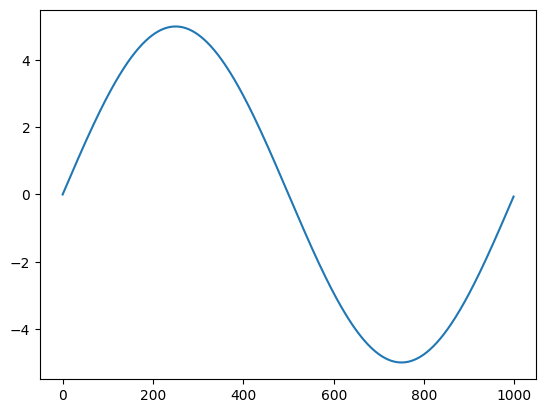

In [115]:
import matplotlib.pyplot as plt
plt.plot(t, meow)

In [17]:
bet1.v_out(3, 2)

In [19]:
bet1.release_device()
bet.release_device()

In [ ]:
devices = ul.get_daq_device_inventory(InterfaceType.ANY)
print(devices)

In [2]:
ul.release_daq_device(0)
ul.release_daq_device(1)

In [ ]:
ul.create_daq_device(0, devices[0])

In [ ]:
ul.create_daq_device(1, devices[1])

In [ ]:
ul.v_in(0,0,ao_range)

In [ ]:
ul.v_in(1,0,ao_range)

In [ ]:
from mcculw import ul
from mcculw.enums import BoardInfo, InfoType, ErrorCode, InterfaceType

def is_device_connected(board_num):
    try:
        # Try to get the board name to check if the device is connected
        board_name = ul.get_board_name(board_num)
        print(f"Device connected at board number {board_num}: {board_name}")
        return True
    except Exception as e:
        print(f"No device connected at board number {board_num}")
        return False

def initialize_device(board_num):
    try:
        # Get the list of available DAQ devices
        devices = ul.get_daq_device_inventory(InterfaceType.ANY)
        if not devices:
            raise Exception('Error: No DAQ devices found')
        
        # Create the DAQ device
        ul.create_daq_device(board_num, devices[board_num])
        print(f"DAQ device {devices[board_num].product_name} created at board number {board_num}")
    except Exception as e:
        print(f"Failed to create DAQ device: {e}")

def connect_devices(max_devices=3):
    for board_num in range(max_devices):
        if not is_device_connected(board_num):
            initialize_device(board_num)

# Run the function to connect up to three devices
connect_devices()


In [ ]:
bet1.idn()

In [24]:
bet.v_out(0, 0, 0)

In [16]:
bet1.v_out(0,0, 0)

In [ ]:
bet.print_specs()

In [ ]:
bet._debug(voltage='1', frequency='50')

In [ ]:
meow

In [ ]:
bet.idn

In [4]:
bet.time_range

In [ ]:
bet.voltage_range

In [1]:
from instrument import Awg
from keysightdsox3024a import Dsox3024a
from pyvisa import ResourceManager

In [2]:
rm = ResourceManager()

In [ ]:
rm.list_resources()

In [4]:
bet = rm.open_resource("GPIB0::7::INSTR")

In [5]:
scope = Dsox3024a(bet)

In [ ]:
scope.idn()

In [ ]:
scope.reset()

In [8]:
bet2 = rm.open_resource("GPIB0::8::INSTR")

In [9]:
awg = Awg(bet2)

In [ ]:
awg.idn()

In [ ]:
from '../measurement_waveforms/discrete_waveform.py' import *